In [1]:
import cv2 as cv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

In [2]:
def get_frames(input_file, i, j):
    cap = cv.VideoCapture(input_file) # RGB format
    if not cap.isOpened():
        raise
    cap.set(1, i)
    ret1, frame1 = cap.read()
    cap.set(1, j)
    ret2, frame2 = cap.read()
    cap.release()
    return frame1, frame2

def plot_frames(frame1, frame2, connections=[], frame_cmap='viridis', connection_cmap='hsv'):
    fig = plt.figure(figsize=(12.8,7.2))
    #fig = plt.figure(figsize=(9.6,7.2))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax2.get_yaxis().set_visible(False)
    ax1.imshow(frame1, cmap=frame_cmap)
    ax2.imshow(frame2, cmap=frame_cmap)
    
    if len(connections) > 0:
        connection_cmap = plt.get_cmap(connection_cmap)
        colors = [connection_cmap(i / len(connections)) for i in range(len(connections))]
        for i, (xy1, xy2) in enumerate(connections):
            con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data", axesA=ax1, axesB=ax2, color=colors[i])
            ax1.plot(xy1[0], xy1[1], 'o', markersize=5, color=colors[i])
            ax2.plot(xy2[0], xy2[1], 'o', markersize=5, color=colors[i])
            ax2.add_artist(con)
        
    plt.show()

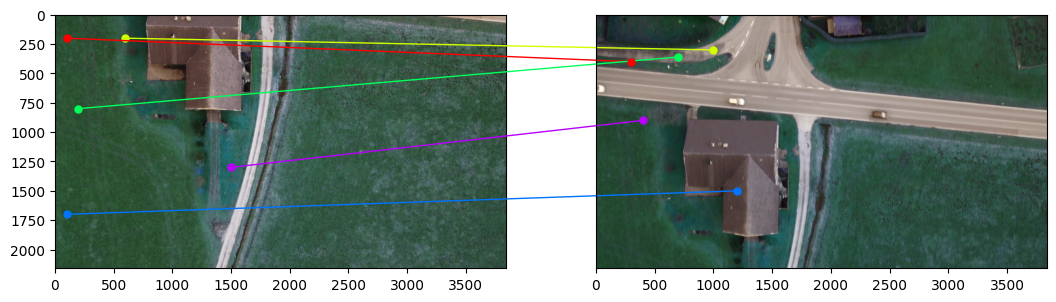

In [3]:
input_file = "../assets/sequence1.mp4"
xy1 = (100,200)
xy2 = (300,400)
frame1, frame2 = get_frames(input_file, 1, 100)
connections = [
    (xy1, xy2), 
    ((600,200),(1000,300)),
    ((200,800),(700,360)),
    ((100,1700),(1200,1500)),
    ((1500,1300),(400,900)),
]
plot_frames(frame1, frame2, connections=connections)

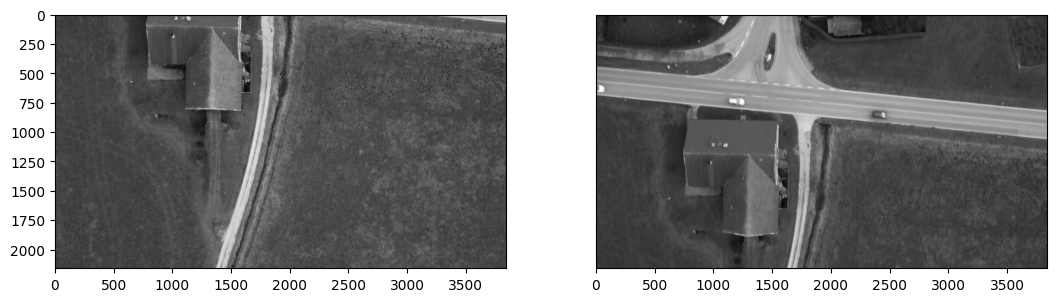

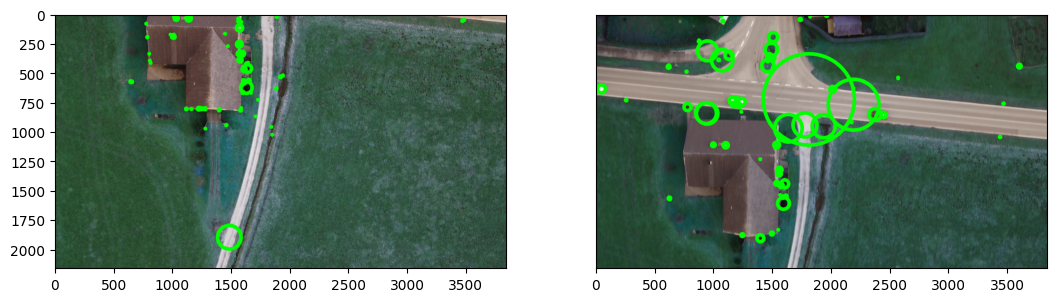

In [4]:
frame1_gray = cv.cvtColor(frame1, cv.COLOR_RGB2GRAY)
frame2_gray = cv.cvtColor(frame2, cv.COLOR_RGB2GRAY)
plot_frames(frame1_gray, frame2_gray, frame_cmap="gray")

def drawKeyPts(img, kp, col, th):
    for curKey in kp:
        x = int(curKey.pt[0])
        y = int(curKey.pt[1])
        size = int(curKey.size)
        cv.circle(img, (x,y), size, col, thickness=th, lineType=8, shift=0) 
    return img

sift1 = cv.SIFT_create(100)
sift2 = cv.SIFT_create(100)
kp1 = sift1.detect(frame1_gray, None)
kp2 = sift2.detect(frame2_gray, None)
#img = cv.drawKeypoints(frame1_gray, kp, frame1, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp1 = drawKeyPts(frame1.copy(), kp1, (0, 255, 0), 30)
img_kp2 = drawKeyPts(frame2.copy(), kp2, (0, 255, 0), 30)
plot_frames(img_kp1, img_kp2)

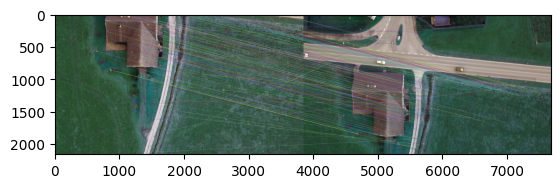

In [5]:
# https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(frame1, None)
kp2, des2 = sift.detectAndCompute(frame2, None)
# BFMatcher with default params

bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

#FLANN_INDEX_KDTREE = 1
#index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
#search_params = dict(checks = 50)
#flann = cv.FlannBasedMatcher(index_params, search_params)
#matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img_matches = cv.drawMatchesKnn(frame1, kp1, frame2, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.show()
cv.imwrite("keypoint_matches.png", img_matches)
None

In [6]:
def do():
    pts1 = np.float32([ kp1[m[0].queryIdx].pt for m in good ])
    pts2 = np.float32([ kp2[m[0].trainIdx].pt for m in good ])
    M, mask = cv.findHomography(pts1, pts2, cv.RANSAC,5.0)

    h, w, _ = frame1.shape
    l = int(np.ceil(np.sqrt(pow(max(h, w), 2) + pow(max(h, w), 2))))
    new_size = (l, l)
    new_shape = (l, l, 3)

    frame2_warped = cv.warpPerspective(frame1, M, dsize=new_size)
    plt.imshow(frame2_warped)
    plt.show()

    frame1_enlarged = np.zeros(new_shape, dtype='int')
    print(new_shape)
    print(l)
    # Here, y_offset+height <= blank_image.shape[0] and x_offset+width <= blank_image.shape[1]
    frame1_enlarged[0:h, 0:w] = frame1



(3135, 3882, 3)


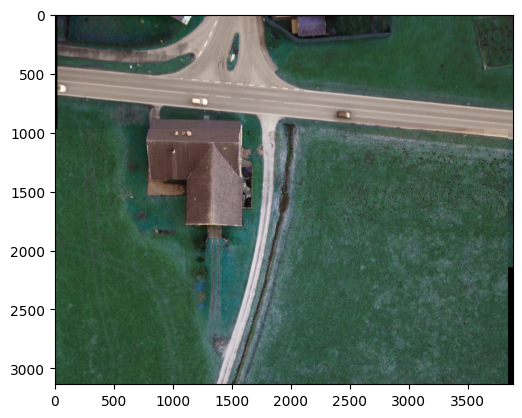

In [21]:
pts1 = np.float32([ kp1[m[0].queryIdx].pt for m in good ])
pts2 = np.float32([ kp2[m[0].trainIdx].pt for m in good ])
H, mask = cv.findHomography(pts2, pts1, cv.RANSAC, 4.0)

h, w, _ = frame2.shape
mat_initial = np.array([[0, w - 1, w - 1, 0], [0, 0, h - 1, h - 1], [1, 1, 1, 1]])
H2 = np.dot(H, mat_initial)

[x, y, c] = H2
x = np.divide(x, c)
y = np.divide(y, c)

min_x, max_x = int(round(min(x))), int(round(max(x)))
min_y, max_y = int(round(min(y))), int(round(max(y)))

new_width = max_x
new_height = max_y
correction = [0, 0]
if min_x < 0:
    new_width -= min_x
    correction[0] = abs(min_x)
if min_y < 0:
    new_height -= min_y
    correction[1] = abs(min_y)

if new_width < frame1.shape[1] + correction[0]:
    new_width = frame1.shape[1] + correction[0]
if new_height < frame1.shape[0] + correction[1]:
    new_height = frame1.shape[0] + correction[1]

x = np.add(x, correction[0])
y = np.add(y, correction[1])
old_pts = np.float32([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]])
new_pts = np.float32(np.array([x, y]).transpose())

H = cv.getPerspectiveTransform(old_pts, new_pts)

img_stitched = cv.warpPerspective(frame2, H, (new_width, new_height))
img_stitched[correction[1]:correction[1]+frame1.shape[0], correction[0]:correction[0]+frame1.shape[1]] = frame1

img_warped = cv.warpPerspective(frame2, H, (new_width, new_height))
img_extended = np.zeros(img_warped.shape, dtype='uint8')
img_extended[
    correction[1]:correction[1]+frame1.shape[0],
    correction[0]:correction[0]+frame1.shape[1]
] = frame1

print(img_stitched.shape)

plt.imshow(img_stitched)
plt.show()

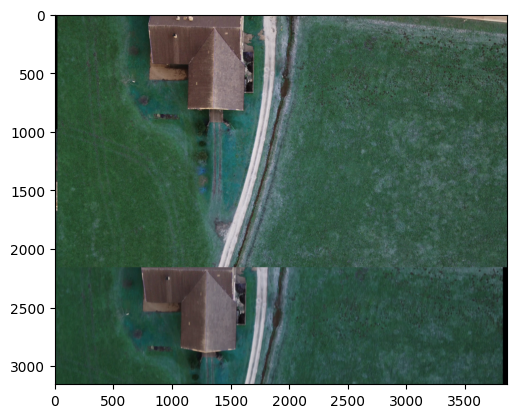

In [8]:
"""Module providing the exit function"""
import sys
import numpy as np
import cv2 as cv


def stitchFrames(frame1, frame2):
    # Find feature points
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(frame1, None)
    kp2, des2 = sift.detectAndCompute(frame2, None)

    # Match correspondences
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    # FLANN_INDEX_KDTREE = 1
    # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # search_params = dict(checks = 50)
    # flann = cv.FlannBasedMatcher(index_params, search_params)
    # matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    # Find the Homography matrix
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])
    H, mask = cv.findHomography(pts1, pts2, cv.RANSAC, 4.0)

    # Calculate the new frame size
    h, w, _ = frame2.shape
    mat_initial = np.array([
        [0, w - 1, w - 1, 0],
        [0, 0, h - 1, h - 1],
        [1, 1, 1, 1]
    ])
    [x, y, c] = np.dot(H, mat_initial)
    x = np.divide(x, c)
    y = np.divide(y, c)
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))
    new_width = max_x
    new_height = max_y
    correction = [0, 0]
    if min_x < 0:
        new_width -= min_x
        correction[0] = abs(min_x)
    if min_y < 0:
        new_height -= min_y
        correction[1] = abs(min_y)
    if new_width < frame1.shape[1] + correction[0]:
        new_width = frame1.shape[1] + correction[0]
    if new_height < frame1.shape[0] + correction[1]:
        new_height = frame1.shape[0] + correction[1]

    x = np.add(x, correction[0])
    y = np.add(y, correction[1])
    old_pts = np.float32([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]])
    new_pts = np.float32(np.array([x, y]).transpose())

    H = cv.getPerspectiveTransform(old_pts, new_pts)

    # Stitch everything together
    img_stitched = cv.warpPerspective(frame2, H, (new_width, new_height))
    img_stitched[
        correction[1]:correction[1]+frame1.shape[0],
        correction[0]:correction[0]+frame1.shape[1]
    ] = frame1

    return img_stitched

output = stitchFrames(frame1, frame2)
plt.imshow(output)
plt.show()

HomographyMatrix [[ 1.00879908e+00  1.34265916e-03  1.93467764e+01]
 [ 1.26237790e-03  9.93789605e-01 -9.75499090e+02]
 [ 6.81060451e-07  3.73621832e-07  1.00000000e+00]]
FinalMatrix [[ 1.93467764e+01  3.89212643e+03  3.89502523e+03  2.22455775e+01]
 [-9.75499090e+02 -9.70652821e+02  1.17493894e+03  1.17009267e+03]
 [ 1.00000000e+00  1.00261459e+00  1.00342124e+00  1.00080665e+00]]
3882 3135 [0, 975] 19 -975
HomographyMatrix 2 [[ 1.00879911e+00  1.34265868e-03  1.93467770e+01]
 [ 1.92641197e-03  9.94153897e-01 -4.99090075e-01]
 [ 6.81074648e-07  3.73608396e-07  1.00000000e+00]]


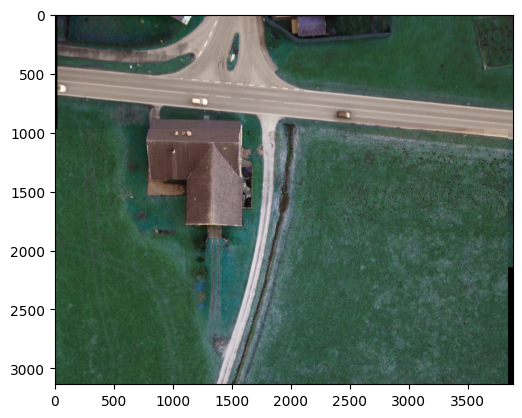

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

      

def FindMatches(BaseImage, SecImage):
    # Using SIFT to find the keypoints and decriptors in the images
    Sift = cv2.SIFT_create()
    BaseImage_kp, BaseImage_des = Sift.detectAndCompute(cv2.cvtColor(BaseImage, cv2.COLOR_BGR2GRAY), None)
    SecImage_kp, SecImage_des = Sift.detectAndCompute(cv2.cvtColor(SecImage, cv2.COLOR_BGR2GRAY), None)

    # Using Brute Force matcher to find matches.
    BF_Matcher = cv2.BFMatcher()
    InitialMatches = BF_Matcher.knnMatch(BaseImage_des, SecImage_des, k=2)

    # Applying ratio test and filtering out the good matches.
    GoodMatches = []
    for m, n in InitialMatches:
        if m.distance < 0.75 * n.distance:
            GoodMatches.append([m])

    return GoodMatches, BaseImage_kp, SecImage_kp



def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match[0].queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match[0].trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix).
    (HomographyMatrix, Status) = cv2.findHomography(SecImage_pts, BaseImage_pts, cv2.RANSAC, 4.0)
    print('HomographyMatrix', HomographyMatrix)
    return HomographyMatrix, Status

    
def GetNewFrameSizeAndMatrix(HomographyMatrix, Sec_ImageShape, Base_ImageShape):
    # Reading the size of the image
    (Height, Width) = Sec_ImageShape
    
    # Taking the matrix of initial coordinates of the corners of the secondary image
    # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
    # Where (xi, yi) is the coordinate of the i th corner of the image. 
    InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                              [0, 0, Height - 1, Height - 1],
                              [1, 1, 1, 1]])

    # Finding the final coordinates of the corners of the image after transformation.
    # NOTE: Here, the coordinates of the corners of the frame may go out of the 
    # frame(negative values). We will correct this afterwards by updating the 
    # homography matrix accordingly.
    FinalMatrix = np.dot(HomographyMatrix, InitialMatrix)
    print('FinalMatrix', FinalMatrix)

    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the stitched image frame and the "Correction" factor
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    New_Width = max_x
    New_Height = max_y
    Correction = [0, 0]
    if min_x < 0:
        New_Width -= min_x
        Correction[0] = abs(min_x)
    if min_y < 0:
        New_Height -= min_y
        Correction[1] = abs(min_y)
    
    # Again correcting New_Width and New_Height
    # Helpful when secondary image is overlaped on the left hand side of the Base image.
    if New_Width < Base_ImageShape[1] + Correction[0]:
        New_Width = Base_ImageShape[1] + Correction[0]
    if New_Height < Base_ImageShape[0] + Correction[1]:
        New_Height = Base_ImageShape[0] + Correction[1]

    # Finding the coordinates of the corners of the image if they all were within the frame.
    x = np.add(x, Correction[0])
    y = np.add(y, Correction[1])
    OldInitialPoints = np.float32([[0, 0],
                                   [Width - 1, 0],
                                   [Width - 1, Height - 1],
                                   [0, Height - 1]])
    NewFinalPonts = np.float32(np.array([x, y]).transpose())

    # Updating the homography matrix. Done so that now the secondary image completely 
    # lies inside the frame
    HomographyMatrix = cv2.getPerspectiveTransform(OldInitialPoints, NewFinalPonts)
    print(New_Width, New_Height, Correction, min_x, min_y)
    print('HomographyMatrix 2', HomographyMatrix)
    return [New_Height, New_Width], Correction, HomographyMatrix



def StitchImages(BaseImage, SecImage):
    # Finding matches between the 2 images and their keypoints
    Matches, BaseImage_kp, SecImage_kp = FindMatches(BaseImage, SecImage)
    
    # Finding homography matrix.
    HomographyMatrix, Status = FindHomography(Matches, BaseImage_kp, SecImage_kp)
    
    # Finding size of new frame of stitched images and updating the homography matrix 
    NewFrameSize, Correction, HomographyMatrix = GetNewFrameSizeAndMatrix(HomographyMatrix, SecImage.shape[:2], BaseImage.shape[:2])

    # Finally placing the images upon one another.
    StitchedImage = cv2.warpPerspective(SecImage, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    StitchedImage[Correction[1]:Correction[1]+BaseImage.shape[0], Correction[0]:Correction[0]+BaseImage.shape[1]] = BaseImage

    return StitchedImage


# Reading the 2 images.
Image1 = frame1.copy()
Image2 = frame2.copy()

# Checking if images read
if Image1 is None or Image2 is None:
    print("\nImages not read properly or does not exist.\n")
    exit(0)

# Calling function for stitching images.
StitchedImage = StitchImages(Image1, Image2)

# Displaying the stitched images.
plt.imshow(StitchedImage)
plt.show()